In [1]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import class_definitions as cd
import function_definitions as fd
import fish_kinematics as fk
import airfoil as ar

from scipy import linalg

%matplotlib inline

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
dx = (0.5*(1-np.cos(beta)))
# uniform spacing
# dx = np.linspace(0.0, chord, 100)
x, y = ar.naca4(dx, 0.12, chord, 0.0, 0.30, True)

(-0.1, 0.1)

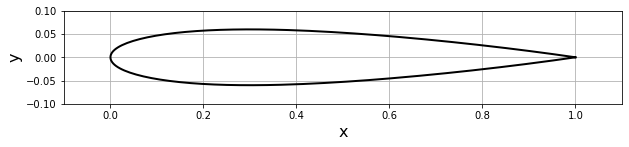

In [3]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

In [4]:
# discretize geoemetry into panels
panels = fd.define_panels(x, y, N=40)

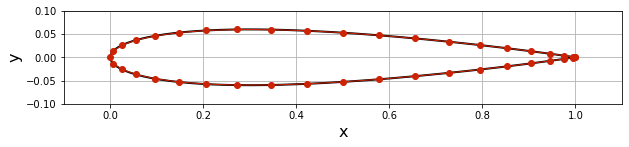

In [5]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

In [6]:
# define freestream conditions
freestream = cd.Freestream(u_inf=1.0, alpha=4.0)

In [7]:
A_source = fd.source_contribution_normal(panels)
B_vortex = fd.vortex_contribution_normal(panels)

In [8]:
A = fd.build_singularity_matrix(A_source, B_vortex)
b = fd.build_freestream_rhs(panels, freestream)

In [9]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [10]:
# tangential velocity at each panel center.
fd.compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [11]:
# surface pressure coefficient
fd.compute_pressure_coefficient(panels, freestream)

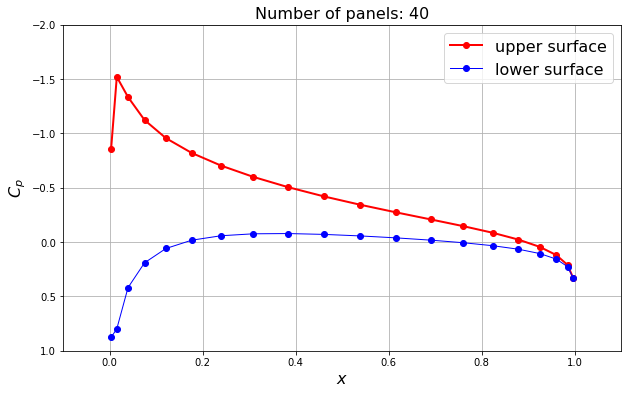

In [13]:
# plot surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -2.0)
plt.title('Number of panels: {}'.format(panels.size), fontsize=16);

Here we define some kinematic parameters that follow the midline of a fish backbone. We use the **Carangiform(w, k, A_n, A_t, x_pivot, total_length)** function in the `fish_kinematics.py` script. The Carangiform class expects a angular frequency **w**, body wave number **k**, the amplitude of the nose and tail **A_n, A_t** and assumes the amplitude at the pivot point is 0. It also requires the position of the pivot point along the body **x_pivot** and the total length of the fish.

In [14]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.489


In [ ]:
total_length = 1.0
velocity = 0.3478
WL = 2.5*total_length         # body wavelength [m]
k = 2*np.pi/WL                # wave number [radians/meter]
freq = 2.47                   # flapping frequency [Hz]
strouhal = 1.136               
A_t = velocity*strouhal/freq    # tail beat amplitude [m]
A_n = 0.01275/total_length
w = 2*np.pi*freq                # angular frequency [radians/sec]                                                         
x_pivot = 0.7                   # pivot in percent of body length

midline = fk.Carangiform(w, k, A_n, A_t, x_pivot, total_length)
dt = 0.05 # time discretization
time = np.arange(0, 1/freq, dt)
U_inf = 1.0
N = 10 # number of wake panels
# set the first trailing edge panel
x_te = np.array([dx[-1], dx[-1] + U_inf*dt])
y_te = midline.single_rigid_motion(x_te, 0.0)
wake_panels = np.empty(1, dtype=object)
wake_panels[0] = cd.Wake_panel(x_te[0], y_te[0], x_te[1], y_te[1])

We discretize the time for 1 flap of the tail. Now we update the curvature of the airfoil and the panels and visualize the results.